In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#데이터 전처리

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing import image


In [28]:
# 데이터 경로
train_data_dir = '/content/drive/MyDrive/Data/img/train'
validation_data_dir = '/content/drive/MyDrive/Data/img/val'
test_data_dir = '/content/drive/MyDrive/Data/img/AffectNet'

In [29]:
# 데이터 증강
train_datagen = ImageDataGenerator(
    rescale=1./255,  # 정규화
    rotation_range=10,  # 이미지 회전 (작은 각도 내에서)
    width_shift_range=0.1,  # 이미지 수평 이동 (작은 범위 내에서)
    height_shift_range=0.1,  # 이미지 수직 이동 (작은 범위 내에서)
    zoom_range=0.2,  # 이미지를 확대/축소
    horizontal_flip=True,  # 이미지를 수평으로 뒤집음 (비대칭성을 고려)
    fill_mode='nearest',  # 이미지 변환 시 발생하는 빈공간을 근처의 픽셀로 채움
    brightness_range=[0.8, 1.2],  # 밝기를 80~120% 무작위 조정
)

# 검증 이미지를 정규화해서 가져옴
val_test_datagen = ImageDataGenerator(rescale=1./255)

# 이미지 불러오기
train_generator = train_datagen.flow_from_directory(
    train_data_dir,  # 훈련 데이터 경로
    target_size=(224, 224),  # 224 사이즈로 가져오기
    batch_size=32,  # 배치 사이즈(한번에 불러올 이미지 개수)
    class_mode='categorical'  # 분류모드-다중 클래스 분류
)

# train_generator와 비슷한 기능
validation_generator = val_test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

#train_generator와 비슷한 기능
test_generator = val_test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)



Found 5996 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.
Found 15392 images belonging to 4 classes.


#MobileNetV2 기반 모델링(실행환경 T4)

In [13]:
#전이학습(특성 추출)
# MobileNetV2 모델 생성 함수
def create_mobilenetv2(input_shape, num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)# MobileNetV2 모델을 기반으로 imagenet 데이터셋으로 사전학습된 가중치를 불러옴/ include_top=false -> 최상위 분류 레이어는 제외
    base_model.trainable = False  # base_model에서는 사전학습 레이어의 가중치를 고정/가중치는 학습되지 않음
    inputs = Input(shape=input_shape) # 입력 레이어
    x = base_model(inputs, training=False)  # base_model에 전달
    x = GlobalAveragePooling2D()(x) # 피처맵 평탄화
    x = Dropout(0.2)(x)  # 드롭아웃 정규화
    outputs = Dense(num_classes, activation='softmax', dtype='float32')(x)  # 출력 형태 및 활성화 함수 정보, dtype은 float32로 명시하여 mixed precision 정책 적용
    model = Model(inputs, outputs) # 모델 생성
    return model

# 모델 생성 및 컴파일
model = create_mobilenetv2(input_shape=(224, 224, 3), num_classes=4)
#Adam 옵티마이저/손실함수 categorical_crossentropy/평가지표는 정확도
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# 학습률 조정 콜백: val_loss가 기준/학습률은 20%로 감소/2에포크동안 개선이 안 되면 학습률 감소/최저 학습률
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# EarlyStopping 콜백:val_loss가 기준/5에포크동안 개선이 없으면 조기 종료/가장 훈련이 좋았던 epoch으로 가중치 복원
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



In [14]:
# 모델 초기 학습 -> 훈련셋/에포크 수/검증셋/콜백기준
history = model.fit(train_generator, epochs=100, validation_data=validation_generator, callbacks=[reduce_lr, early_stopping])

Epoch 1/100
188/188 [==============================] - 467s 2s/step - loss: 1.5031 - accuracy: 0.3110 - val_loss: 1.4050 - val_accuracy: 0.3133 - lr: 0.0010
Epoch 2/100
188/188 [==============================] - 473s 3s/step - loss: 1.3875 - accuracy: 0.3652 - val_loss: 1.3723 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 3/100
188/188 [==============================] - 472s 3s/step - loss: 1.3365 - accuracy: 0.3878 - val_loss: 1.4522 - val_accuracy: 0.3467 - lr: 0.0010
Epoch 4/100
188/188 [==============================] - 484s 3s/step - loss: 1.3207 - accuracy: 0.3999 - val_loss: 1.3927 - val_accuracy: 0.3375 - lr: 0.0010
Epoch 5/100
188/188 [==============================] - 492s 3s/step - loss: 1.2669 - accuracy: 0.4244 - val_loss: 1.3607 - val_accuracy: 0.3642 - lr: 2.0000e-04
Epoch 6/100
188/188 [==============================] - 481s 3s/step - loss: 1.2582 - accuracy: 0.4320 - val_loss: 1.3547 - val_accuracy: 0.3675 - lr: 2.0000e-04
Epoch 7/100
188/188 [=============================

In [15]:
#파인튜닝과정
base_model = model.layers[1]
base_model.trainable = True

#사전 학습된 모델의 전체 레이어 갯수 가져오
num_layers = len(base_model.layers)

# 훈련되지 않고 고정될 레이어 비율
freeze_ratio = 0.7
num_freeze_layers = int(num_layers * freeze_ratio)

# 하위 레이어 고정, 상위 레이어 해제
for layer in base_model.layers[:num_freeze_layers]:
    layer.trainable = False
for layer in base_model.layers[num_freeze_layers:]:
    layer.trainable = True

#Adam 옵티마이저/손실함수 categorical_crossentropy/평가지표는 정확도
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
history_fine = model.fit(train_generator, epochs=100, validation_data=validation_generator, callbacks=[reduce_lr, early_stopping])

Epoch 1/100
188/188 [==============================] - 467s 2s/step - loss: 1.1675 - accuracy: 0.4792 - val_loss: 1.1044 - val_accuracy: 0.5133 - lr: 1.0000e-04
Epoch 2/100
188/188 [==============================] - 464s 2s/step - loss: 0.9112 - accuracy: 0.6139 - val_loss: 1.0565 - val_accuracy: 0.5658 - lr: 1.0000e-04
Epoch 3/100
188/188 [==============================] - 463s 2s/step - loss: 0.7835 - accuracy: 0.6846 - val_loss: 0.9405 - val_accuracy: 0.6058 - lr: 1.0000e-04
Epoch 4/100
188/188 [==============================] - 462s 2s/step - loss: 0.7251 - accuracy: 0.7088 - val_loss: 0.9599 - val_accuracy: 0.6225 - lr: 1.0000e-04
Epoch 5/100
188/188 [==============================] - 483s 3s/step - loss: 0.6642 - accuracy: 0.7362 - val_loss: 0.8691 - val_accuracy: 0.6458 - lr: 1.0000e-04
Epoch 6/100
188/188 [==============================] - 472s 3s/step - loss: 0.6031 - accuracy: 0.7612 - val_loss: 1.0617 - val_accuracy: 0.6275 - lr: 1.0000e-04
Epoch 7/100
188/188 [=============

In [16]:
# 검증 데이터 확인
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

38/38 [==============================] - 68s 2s/step - loss: 0.8691 - accuracy: 0.6458
Validation Loss: 0.8690553903579712
Validation Accuracy: 0.6458333134651184


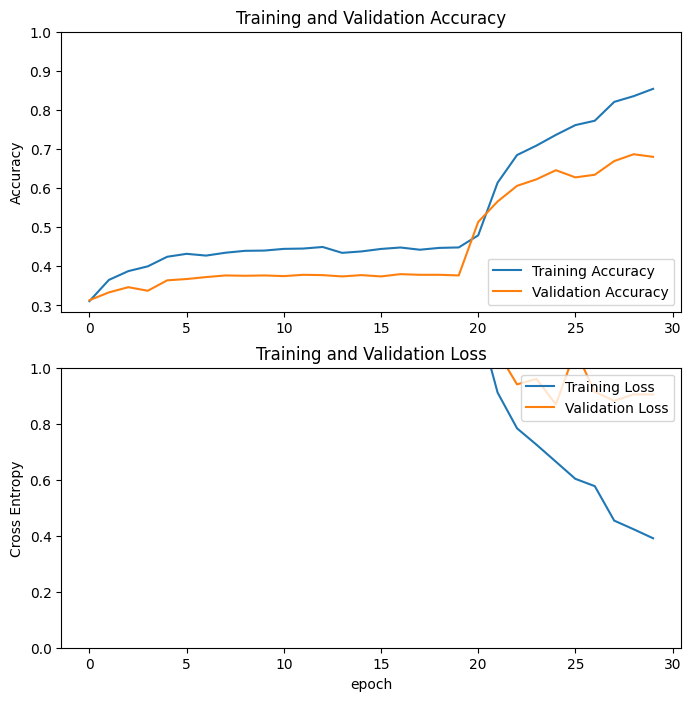

In [17]:
# 결과 그래프 출력
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# 테스트 데이터 전체 검증
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


278/481 [================>.............] - ETA: 8:40 - loss: 1.3874 - accuracy: 0.3611

In [24]:
# 모델 저장
model.save('my_model_MobileNetV2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#임의의 이미지로 모델 성능 test

In [ ]:
# 이미지 전처리 함수
def load_and_prepare_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.0  # 정규화
    return img_tensor

# 감정을 예측하는 함수
def predict_emotion(model, img_path):
    print("이미지 로딩 중...")
    test_image = load_and_prepare_image(img_path)
    print("감정 예측 중...")
    prediction = model.predict(test_image)
    return prediction

# 모델 경로와 이미지 경로
model_path = '/content/my_model_MobileNetV2.h5'  # 학습된 모델 경로
image_path = '/content/drive/MyDrive/test/1.jpg'  # 테스트할 이미지 경로

# 모델 로드
model = load_model(model_path)

# 예측 결과 얻기
predictions = predict_emotion(model, image_path)
emotion_index = np.argmax(predictions)
emotion_labels = ['화남', '행복', '슬픔', '충격']  # 실제 감정 레이블로 변경

print("예측된 감정:", emotion_labels[emotion_index])
print("각 감정의 비율:")
for i, label in enumerate(emotion_labels):
    print(f"{label}: {predictions[0][i] * 100:.2f}%")


이미지 로딩 중...
감정 예측 중...


1/1 [==============================] - 1s 704ms/step
예측된 감정: 행복
각 감정의 비율:
화남: 4.20%
행복: 79.71%
슬픔: 1.21%
충격: 14.88%
